# Chessboard detection

In [1]:
import imageio, tqdm
import numpy as np
import joblib
import matplotlib.pyplot as plt
import cv2, os, time, glob
import networkx as nx
na = np.newaxis

def orient_board(uvs, markers, board=(7,10)):
    """flip order of chessboard points so that first is farthest from markers"""
    
    distance = np.sqrt(((uvs - markers.mean(1)[:,na,:])**2).sum(-1))
    flip = distance[:,0] < distance[:,-1]
    
    cols,rows = board
    uvs[flip] = uvs[flip].reshape(-1,rows,cols,2)[:,::-1].reshape(-1,rows*cols,2)   
    return uvs

board = (7,10)

prefixes = []
img_sizes = []
all_chessboard_uvs = []

# load and orient chessboard detections
calib_dir = '../../../../data/23_3_16_calibration/'
for path in tqdm.tqdm(glob.glob(calib_dir+'/*.corners.p')):
    
    prefix = path.split('.corners')[0]
    uvs,ixs = map(np.array,joblib.load(path))
    markers = joblib.load(prefix+'.circle_plus.p')['uv']
    uvs = orient_board(uvs, markers[ixs], board=board)
    chessboard_uvs = np.zeros((18001,70,2))*np.nan
    chessboard_uvs[ixs] = uvs

    all_chessboard_uvs.append(chessboard_uvs)
    prefixes.append(prefix)

all_calib_uvs = np.array(all_chessboard_uvs)

img_sizes = [
    (1280, 1024),
    (1280, 1024),
    (1280, 832),
    (1280, 832),
    (1280, 832),
    (1280, 832)]

  0%|                                                                                                                        | 0/6 [00:00<?, ?it/s]


EOFError: 

# Initial calibration

In [2]:
from multicam_calibration import calibrate, plot_residuals, chessboard, bundle_adjust

In [3]:
chess_board_shape = (7,10)
chess_board_square_size = 12.5
calib_objpoints = chessboard.generate_objpoints(chess_board_shape, chess_board_square_size)

all_extrinsics, all_intrinsics, calib_poses = calibrate(
    all_calib_uvs, img_sizes, calib_objpoints, root=0)


Estimating camera intrinsics


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:21<00:00,  3.66s/it]


Initializing calibration object poses


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:11<00:00,  1.96s/it]

Estimating camera extrinsics
Merging calibration object poses


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


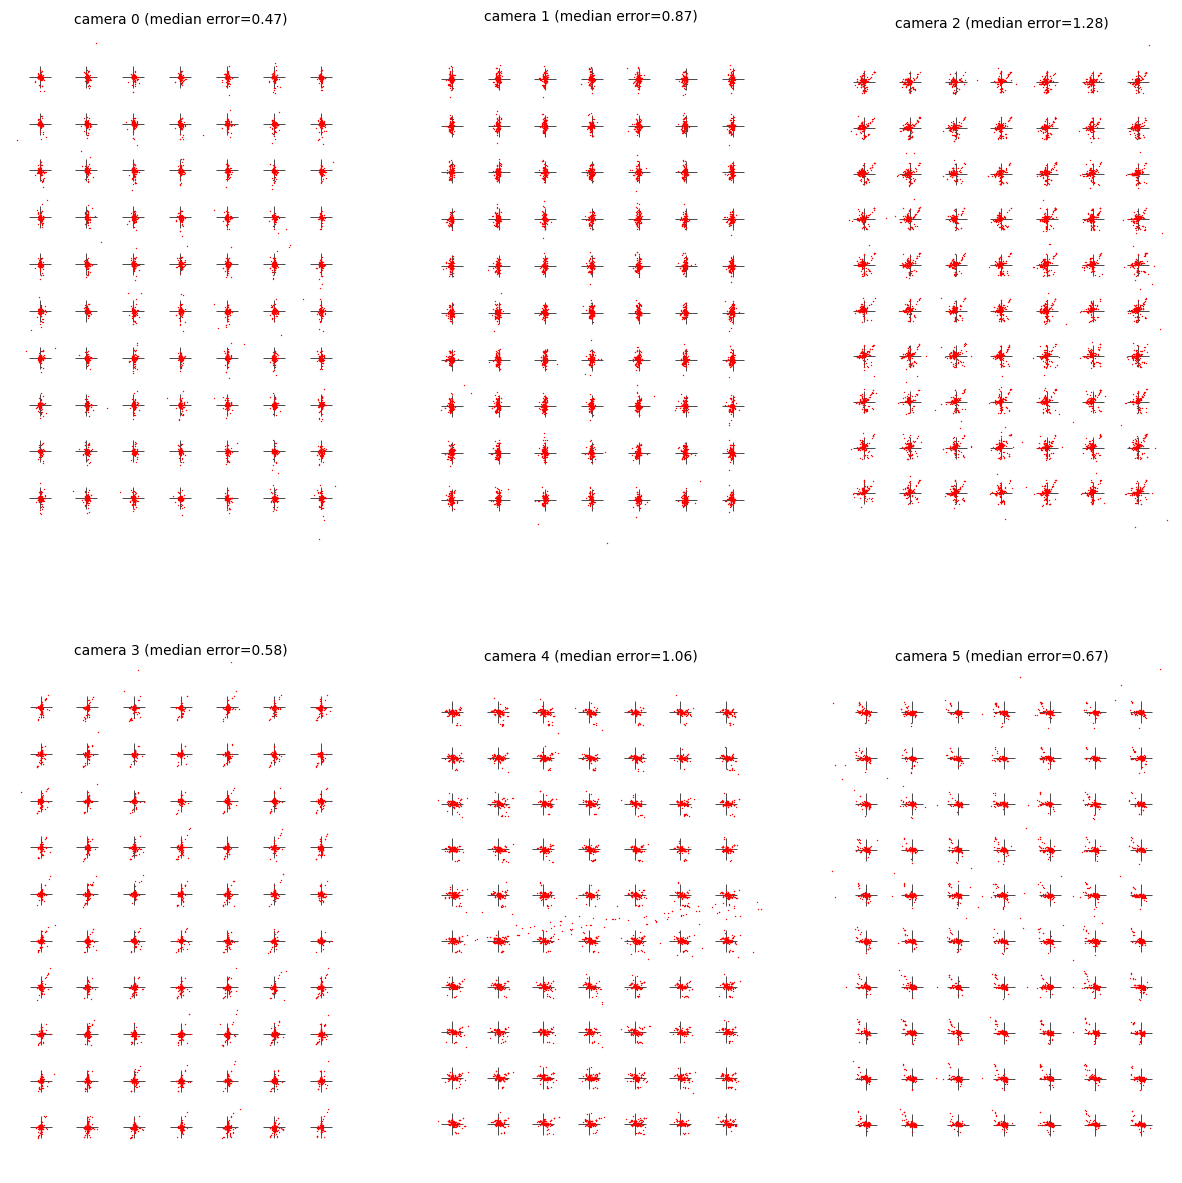

In [4]:
fig, mean_squared_error, reprojections, transformed_reprojections = plot_residuals(
    all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses)

# Bundle Adjustment

In [14]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=5000, ftol=1e-4)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2252e+06                                    5.40e+07    
       1              4         1.0461e+06      1.79e+05       5.92e+01       3.56e+07    
       2              5         8.0329e+05      2.43e+05       1.81e+01       2.21e+07    
       3              6         7.5357e+05      4.97e+04       3.65e+01       6.59e+06    
       4              7         7.0243e+05      5.11e+04       1.22e+01       3.67e+06    
       5              8         6.8831e+05      1.41e+04       2.71e+01       3.01e+06    
       6              9         6.6972e+05      1.86e+04       6.87e+00       2.72e+06    
       7             10         6.6590e+05      3.82e+03       1.37e+01       2.74e+06    
       8             11         6.5963e+05      6.27e+03       3.73e+00       2.76e+06    
       9             12         6.5579e+05      3.84e+03       4.95e+00       2.47e+06    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.08it/s]


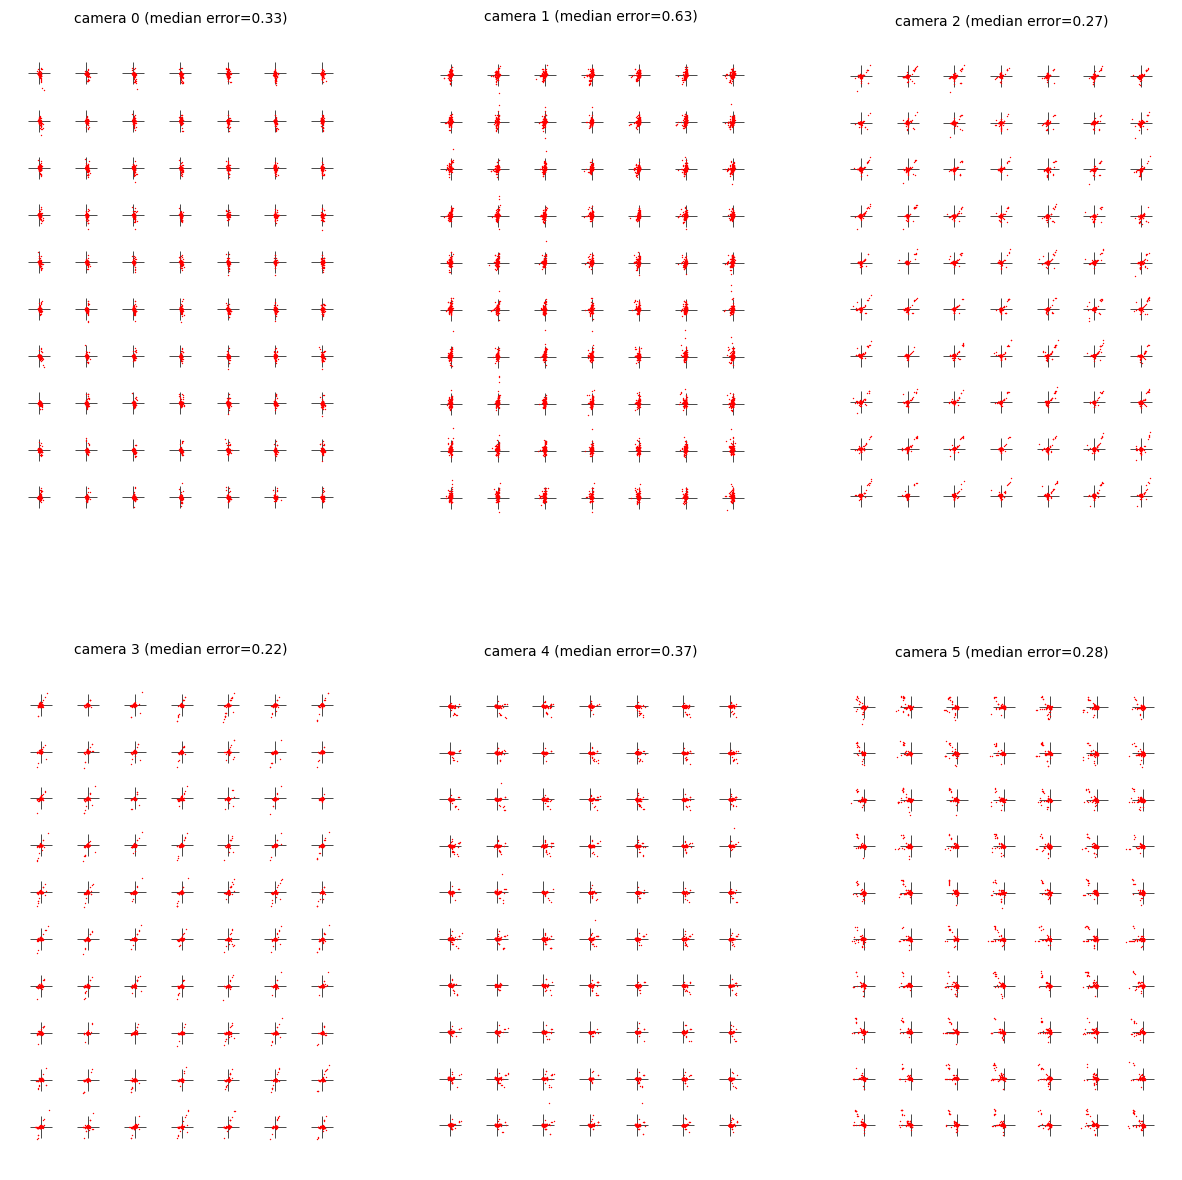

In [15]:
fig, median_error, reprojections, transformed_reprojections = plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses)

In [19]:
save_path = '../../../../23_4_5_multianimal_annotations/jarvis/sofia_3d_annotations/CalibrationParameters/'
camera_names = ['top', 'bottom', 'side2', 'side4', 'side1', 'side3']
save_calibration(all_extrinsics, all_intrinsics, camera_names, save_path, save_format='jarvis')

In [11]:
from multicam_calibration import load_calibration, save_calibration

calib = load_calibration('../../../23_3_16_calibration_results.json', load_format='json')
save_calibration(*calib, '../../../23_3_16_calibration_results.h5', save_format='gimbal')

In [14]:
ls ../../../

23_3_16_calibration_results/      calibration_printout1.png
23_3_16_calibration_results.h5    calibration_printout2.png
23_3_16_calibration_results.json  circle_plus_config.yml
calibration_printout1.pdf         multicam-calibration/


In [18]:
import h5py
h5py.File('../../../23_3_16_calibration_results.h5','r')['camera_parameters'].keys()

<KeysViewHDF5 ['camera_names', 'dist_coefs', 'intrinsic', 'rotation', 'translation']>

In [5]:
len(calib[1])

6

In [6]:
len(calib[2])

6

In [7]:
calib[2]

['bottom', 'side1', 'side2', 'side3', 'side4', 'top']